In [32]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from itertools import product
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pyplot as plt



In [33]:
def manual_error_rate(df, models=None, proba=False, diag=False):
    features = df['feature']
    labels = df['label']

    arr_len = len(features[0])
    tot_enumerations = 2**arr_len

    permutations = list(product([0, 1], repeat=arr_len))

    results = []
    results_p_1 = []
    results_p_2 = []
    results_p_3 = [] ###

    for perm in tqdm(permutations, total=tot_enumerations, desc="Processing permutations"):
        perm_array = np.array(perm)
        count = 0
        error_count = 0

        for feature, label in zip(features, labels):
            if np.array_equal(feature, perm_array):
                count += 1
                if label == 0:
                    error_count += 1
        if count > 0:
          error_rate = (error_count / count)
          results.append([perm, error_rate])
          proba_score = 0
          if proba:
            # probability that prediction is 0
            rf_score = models[0].predict_proba(np.array(perm).reshape(1, -1))[0][0]
            lr_score = models[1].predict_proba(np.array(perm).reshape(1, -1))[0][0]
            kn_score = models[2].predict_proba(np.array(perm).reshape(1, -1))[0][0]
            results_p_1.append([perm, rf_score])
            results_p_2.append([perm, lr_score])
            results_p_3.append([perm, kn_score])
          if diag: print(f"permutation {perm}: manual error rate is {error_rate*100:.2f}%, proba_score is {proba_score*100:.2f}% appears {count} times")

    if proba: return np.array(results, dtype=object), np.array(results_p_1, dtype=object), np.array(results_p_2, dtype=object), np.array(results_p_3, dtype=object)
    else: return np.array(results, dtype=object)


def repopulate_sample(sample, total_manual, model=None):
    tmp = []
    avg_value = np.mean(sample[:, 1].astype(float))
    for i, entry in enumerate(total_manual):
        exist = next((row for row in sample if row[0] == entry[0]), None)
        if exist is not None:
            tmp.append([exist[0], exist[1]])
        else:
            if model is not None:
                tmp.append([entry[0], model.predict_proba(np.array(entry[0]).reshape(1, -1))[0][0]])
            else:
                tmp.append([entry[0], avg_value])
    return np.array(tmp, dtype=object)

# Grid Search for Plot Generation

In [38]:
all_features = np.arange(4, 13)
all_sample_sizes = [100, 500, 5000, 10000]


orig_reconstruct = pd.read_csv("rec.csv")
orig_reconstruct["feature"] = orig_reconstruct["feature"].apply(ast.literal_eval)
orig_reconstruct["feature"] = orig_reconstruct["feature"].apply(lambda x: x[-1:] + x[:-1])

#grid search features and sample sizes (brute force all and get array of all combination [ratio, hardness])

all_rfv = []
all_rlv = []
all_knv = []
all_msv = []

results = []
for feature_size in all_features:
    print(f" ---- Testing feature size: {feature_size} ---- ")
    # ---- Load CNN Model Preds ----
    #clip each feature from the right (.ie if each feature has length 14 and i spefcify feature size of 12, remove the right 2 elements from each feature)
    reconstruct = orig_reconstruct.copy()
    reconstruct["feature"] = reconstruct["feature"].apply(lambda x: x[:feature_size])
    print("Calculating Total Manual Error Rates")
    total_manual = manual_error_rate(reconstruct)

    for sample_size in all_sample_sizes:
        print(f"## Sample size: {sample_size}")
        # ---- Sample Set ----
        sample_set = reconstruct.sample(n=sample_size, random_state=42).reset_index(drop=True)

        # ---- Error Pred Models ----
        rf = RandomForestClassifier(random_state=42)
        rf.fit(list(sample_set['feature']), sample_set['label'])
        lr = LogisticRegression(random_state=42)
        lr.fit(list(sample_set['feature']), sample_set['label'])
        knn = KNeighborsClassifier() ###
        knn.fit(list(sample_set['feature']), sample_set['label']) ###
        

        # ---- Calculate all 3 Error Rates ----
        print("Calculating Sample Manual and Proba Error Rates")
        manual_sample, rf_sample, lr_sample, knn_sample = manual_error_rate(sample_set, models=[rf, lr, knn], proba=True, diag=False)
        manual_sample = repopulate_sample(manual_sample, total_manual)
        rf_sample = repopulate_sample(rf_sample, total_manual, model=rf)
        lr_sample = repopulate_sample(lr_sample, total_manual, model=lr)
        knn_sample = repopulate_sample(knn_sample, total_manual, model=knn)

        rf_vs_mt = np.sum((total_manual[:, 1] - rf_sample[:, 1]) ** 2)
        lr_vs_mt = np.sum((total_manual[:, 1] - lr_sample[:, 1]) ** 2)
        knn_vs_mt = np.sum((total_manual[:, 1] - knn_sample[:, 1]) ** 2)
        ms_vs_mt = np.sum((total_manual[:, 1] - manual_sample[:, 1]) ** 2)

        all_rfv.append(rf_vs_mt)
        all_rlv.append(lr_vs_mt)
        all_knv.append(knn_vs_mt)
        all_msv.append(ms_vs_mt)

        rf_ratio = rf_vs_mt / ms_vs_mt
        lr_ratio = lr_vs_mt / ms_vs_mt
        knn_ratio = knn_vs_mt / ms_vs_mt
        hardness = sample_size / (2 ** feature_size)
        print(f"-> RF Ratio: {rf_ratio:.2f}, LR Ratio: {lr_ratio:.2f}, KNN Ratio: {knn_ratio:.2f}, Hardness: {hardness:.2f}")
        results.append([feature_size, sample_size, rf_ratio, lr_ratio, knn_ratio, hardness])
    
    print()

 ---- Testing feature size: 4 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 16/16 [00:01<00:00, 14.18it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 16/16 [00:00<00:00, 973.11it/s]


-> RF Ratio: 1.60, LR Ratio: 1.23, KNN Ratio: 2.31, Hardness: 6.25
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 16/16 [00:00<00:00, 517.73it/s]


-> RF Ratio: 1.75, LR Ratio: 2.73, KNN Ratio: 3.91, Hardness: 31.25
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 16/16 [00:00<00:00, 63.89it/s]


-> RF Ratio: 1.31, LR Ratio: 3.63, KNN Ratio: 2.53, Hardness: 312.50
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 16/16 [00:00<00:00, 36.29it/s]


-> RF Ratio: 1.71, LR Ratio: 3.82, KNN Ratio: 2.92, Hardness: 625.00

 ---- Testing feature size: 5 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 32/32 [00:02<00:00, 13.94it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 32/32 [00:00<00:00, 946.50it/s]


-> RF Ratio: 1.54, LR Ratio: 0.99, KNN Ratio: 1.85, Hardness: 3.12
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 32/32 [00:00<00:00, 482.07it/s]


-> RF Ratio: 2.02, LR Ratio: 2.07, KNN Ratio: 4.51, Hardness: 15.62
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 32/32 [00:00<00:00, 75.00it/s]


-> RF Ratio: 0.54, LR Ratio: 1.47, KNN Ratio: 2.43, Hardness: 156.25
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 32/32 [00:00<00:00, 50.33it/s]


-> RF Ratio: 1.12, LR Ratio: 2.34, KNN Ratio: 3.86, Hardness: 312.50

 ---- Testing feature size: 6 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 64/64 [00:04<00:00, 13.59it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 64/64 [00:00<00:00, 1327.29it/s]


-> RF Ratio: 1.28, LR Ratio: 0.79, KNN Ratio: 1.83, Hardness: 1.56
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 64/64 [00:00<00:00, 665.25it/s]


-> RF Ratio: 0.85, LR Ratio: 0.74, KNN Ratio: 1.75, Hardness: 7.81
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 64/64 [00:00<00:00, 93.55it/s] 


-> RF Ratio: 0.60, LR Ratio: 1.23, KNN Ratio: 2.12, Hardness: 78.12
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 64/64 [00:01<00:00, 54.81it/s]


-> RF Ratio: 0.83, LR Ratio: 2.08, KNN Ratio: 3.40, Hardness: 156.25

 ---- Testing feature size: 7 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 128/128 [00:09<00:00, 13.46it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 128/128 [00:00<00:00, 1783.93it/s]


-> RF Ratio: 1.08, LR Ratio: 0.68, KNN Ratio: 1.38, Hardness: 0.78
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 128/128 [00:00<00:00, 662.56it/s]


-> RF Ratio: 1.12, LR Ratio: 0.56, KNN Ratio: 1.49, Hardness: 3.91
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 128/128 [00:01<00:00, 102.45it/s]


-> RF Ratio: 0.92, LR Ratio: 1.23, KNN Ratio: 2.71, Hardness: 39.06
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 128/128 [00:02<00:00, 54.63it/s]


-> RF Ratio: 0.90, LR Ratio: 1.35, KNN Ratio: 2.59, Hardness: 78.12

 ---- Testing feature size: 8 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 256/256 [00:19<00:00, 13.39it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 256/256 [00:00<00:00, 2534.55it/s]


-> RF Ratio: 1.04, LR Ratio: 0.76, KNN Ratio: 1.37, Hardness: 0.39
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 256/256 [00:00<00:00, 839.21it/s]


-> RF Ratio: 1.04, LR Ratio: 0.62, KNN Ratio: 1.26, Hardness: 1.95
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 256/256 [00:02<00:00, 109.19it/s]


-> RF Ratio: 0.83, LR Ratio: 0.82, KNN Ratio: 1.59, Hardness: 19.53
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 256/256 [00:04<00:00, 57.53it/s]


-> RF Ratio: 0.91, LR Ratio: 1.05, KNN Ratio: 1.70, Hardness: 39.06

 ---- Testing feature size: 9 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 512/512 [00:39<00:00, 13.04it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 512/512 [00:00<00:00, 3710.66it/s]


-> RF Ratio: 1.09, LR Ratio: 0.87, KNN Ratio: 1.45, Hardness: 0.20
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 512/512 [00:00<00:00, 963.59it/s] 


-> RF Ratio: 0.95, LR Ratio: 0.60, KNN Ratio: 1.10, Hardness: 0.98
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 512/512 [00:04<00:00, 111.55it/s]


-> RF Ratio: 0.79, LR Ratio: 0.64, KNN Ratio: 1.18, Hardness: 9.77
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 512/512 [00:08<00:00, 58.10it/s]


-> RF Ratio: 0.79, LR Ratio: 0.78, KNN Ratio: 1.19, Hardness: 19.53

 ---- Testing feature size: 10 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 1024/1024 [01:20<00:00, 12.68it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 1024/1024 [00:00<00:00, 3815.91it/s]


-> RF Ratio: 1.11, LR Ratio: 0.93, KNN Ratio: 1.56, Hardness: 0.10
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 1024/1024 [00:01<00:00, 1022.48it/s]


-> RF Ratio: 1.02, LR Ratio: 0.67, KNN Ratio: 1.06, Hardness: 0.49
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 1024/1024 [00:09<00:00, 110.79it/s]


-> RF Ratio: 0.80, LR Ratio: 0.66, KNN Ratio: 1.03, Hardness: 4.88
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 1024/1024 [00:18<00:00, 56.74it/s]


-> RF Ratio: 0.79, LR Ratio: 0.74, KNN Ratio: 0.98, Hardness: 9.77

 ---- Testing feature size: 11 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 2048/2048 [02:46<00:00, 12.27it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 2048/2048 [00:00<00:00, 4629.02it/s]


-> RF Ratio: 1.09, LR Ratio: 0.98, KNN Ratio: 1.49, Hardness: 0.05
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 2048/2048 [00:01<00:00, 1046.88it/s]


-> RF Ratio: 0.99, LR Ratio: 0.75, KNN Ratio: 1.06, Hardness: 0.24
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 2048/2048 [00:18<00:00, 111.86it/s]


-> RF Ratio: 0.76, LR Ratio: 0.70, KNN Ratio: 0.92, Hardness: 2.44
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 2048/2048 [00:36<00:00, 56.35it/s]


-> RF Ratio: 0.81, LR Ratio: 0.85, KNN Ratio: 0.97, Hardness: 4.88

 ---- Testing feature size: 12 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 4096/4096 [05:41<00:00, 12.01it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 4096/4096 [00:00<00:00, 5062.62it/s]


-> RF Ratio: 1.04, LR Ratio: 0.99, KNN Ratio: 1.28, Hardness: 0.02
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 4096/4096 [00:03<00:00, 1098.58it/s]


-> RF Ratio: 1.04, LR Ratio: 0.83, KNN Ratio: 1.11, Hardness: 0.12
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 4096/4096 [00:38<00:00, 106.61it/s]


-> RF Ratio: 0.81, LR Ratio: 0.79, KNN Ratio: 0.99, Hardness: 1.22
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 4096/4096 [01:15<00:00, 54.29it/s]


-> RF Ratio: 0.84, LR Ratio: 0.94, KNN Ratio: 1.09, Hardness: 2.44



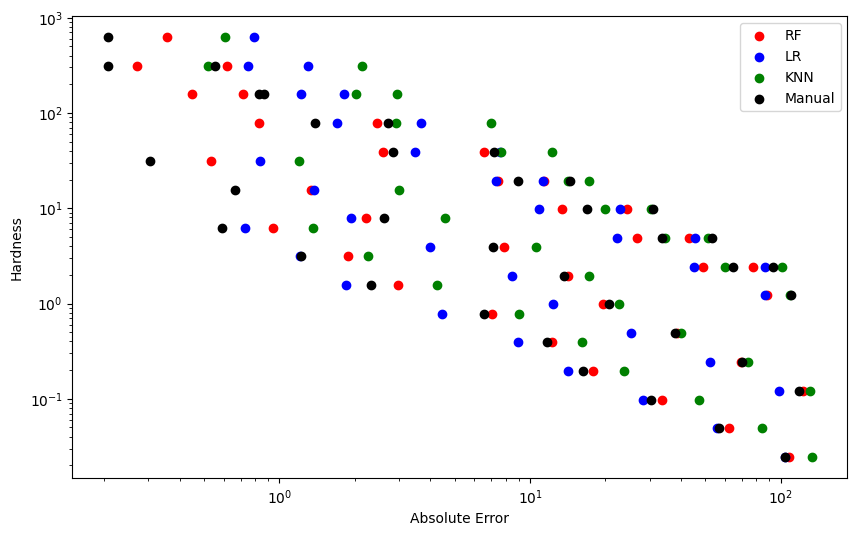

In [41]:
#plot absolute values of allrfv, allrlv, allknv, allmsv vs hardness and plot them in different colors

results = np.array(results)
all_rfv = np.array(all_rfv)
all_rlv = np.array(all_rlv)
all_knv = np.array(all_knv)
all_msv = np.array(all_msv)

plt.figure(figsize=(10, 6))
plt.scatter(abs(all_rfv), results[:, 5], color='red', label='RF')
plt.scatter(abs(all_rlv), results[:, 5], color='blue', label='LR')
plt.scatter(abs(all_knv), results[:, 5], color='green', label='KNN')
plt.scatter(abs(all_msv), results[:, 5], color='black', label='Manual')
plt.xlabel('Absolute Error')
plt.ylabel('Hardness')
#log scale
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()



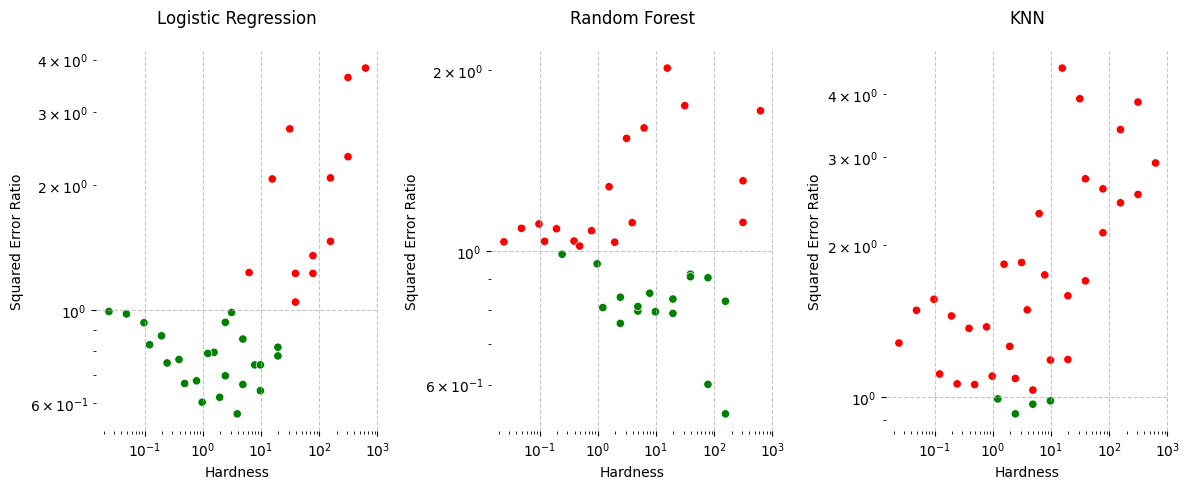

RF: 50.00% are below 1
LR: 66.67% are below 1
KNN: 11.11% are below 1


In [36]:
np_results = np.array(results)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Left plot: using y column index 3
sns.scatterplot(ax=axes[0],
                x=np_results[:, 5],
                y=np_results[:, 3],
                hue=np_results[:, 3] < 1,
                palette={True: 'green', False: 'red'},
                legend=False)
axes[0].set_xlabel('Hardness')
axes[0].set_ylabel('Squared Error Ratio')
axes[0].set_title('Logistic Regression', pad=20)
axes[0].grid(True, linestyle='--', alpha=0.7)
for spine in axes[0].spines.values():
    spine.set_visible(False)
# Apply log scale to both axes for left plot
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Right plot: using y column index 2
sns.scatterplot(ax=axes[1],
                x=np_results[:, 5],
                y=np_results[:, 2],
                hue=np_results[:, 2] < 1,
                palette={True: 'green', False: 'red'},
                legend=False)
axes[1].set_xlabel('Hardness')
axes[1].set_ylabel('Squared Error Ratio')
axes[1].set_title('Random Forest', pad=20)
axes[1].grid(True, linestyle='--', alpha=0.7)
for spine in axes[1].spines.values():
    spine.set_visible(False)
# Apply log scale to both axes for right plot
axes[1].set_xscale('log')
axes[1].set_yscale('log')

sns.scatterplot(ax=axes[2],
                x=np_results[:, 5],
                y=np_results[:, 4],
                hue=np_results[:, 4] < 1,
                palette={True: 'green', False: 'red'},
                legend=False)
axes[2].set_xlabel('Hardness')
axes[2].set_ylabel('Squared Error Ratio')
axes[2].set_title('KNN', pad=20)
axes[2].grid(True, linestyle='--', alpha=0.7)
for spine in axes[2].spines.values():
    spine.set_visible(False)
# Apply log scale to both axes for right plot
axes[2].set_xscale('log')
axes[2].set_yscale('log')


plt.tight_layout()
plt.show()

rf_percentage = np.sum(np_results[:, 2] < 1) / len(np_results)
lr_percentage = np.sum(np_results[:, 3] < 1) / len(np_results)
knn_percentage = np.sum(np_results[:, 4] < 1) / len(np_results)
print(f"RF: {rf_percentage*100:.2f}% are below 1")
print(f"LR: {lr_percentage*100:.2f}% are below 1")
print(f"KNN: {knn_percentage*100:.2f}% are below 1")


#save results